# Effect of missing bands in estimations
In this notebook, we check how the physical estimates retrieved by CIGALE could change when different bands are missing in the fitting. First we import the Python packages.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle

import astropy.units as u
from astropy.table import Table, join

## Read files and merge them
We read the files containing the information of the photometry, type and derived physical parameters. We merge them to do the analysis.

In [2]:
# Photometry
Phot = Table.read('../Data/Final/CIGPhot_EnergyBal_All.tbl',
                  format='ascii')
# Create a column with the number of available bands
Phot['Nbands'] = [sum(~np.isnan(list(row)[2::2])) for row in Phot]

# General information of the sample
Sample = Table.read('../Data/Final/VCV_SMB_otype.txt', format='ascii')
# Renamed to use the join with the same id
Sample.rename_column('main_id', 'id')

# Derived physical parameters from CIGALE
ModelS = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_SK.fits',
                    format='fits')
ModelF = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_Fr.fits',
                    format='fits')

ModelS37 = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_SK37.fits',
                      format='fits')
ModelF37 = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_Fr37.fits',
                      format='fits')

We create a column for each photometry band to flag if the band exist for a given galaxy.

In [3]:
for icol, col in enumerate(Phot.columns[2:-1:2]):
    Phot['Exists_'+col] = ~np.isnan(Phot[col])

We join the samples

In [4]:
NSample = join(Sample['id', 'otype_txt', 'Sp'], Phot)

SPandas = join(NSample, ModelS, keys='id').to_pandas()
FPandas = join(NSample, ModelF, keys='id').to_pandas()
SPandas37 = join(NSample, ModelS37, keys='id').to_pandas()
FPandas37 = join(NSample, ModelF37, keys='id').to_pandas()
SFPandas = pd.concat([SPandas, FPandas, SPandas37, FPandas37],
                     keys=['SKIRTOR', 'Fritz', 'S37', 'F37'], names=['Model', 'idCIG'])

## Derived physical parameters
Here we select the 7 most important parameters (as described in the notebook [11_Analysis_Tables](../Notebooks/11_Analysis_Tables.ipynb)), and we put them in the required units to be able to work with them more easily.

In [5]:
param_check = ['bayes.agn.i', 'bayes.agn.fracAGN', 'bayes.agn.disk_luminosity', 'bayes.agn.EBV',
               'bayes.attenuation.E_BVs', 'bayes.sfh.tau_main', 'bayes.sfh.sfr']

param_label = ['View. Angle', r'$f_{\rm{AGN}}$', r'$\rm{L}_{\rm{AGN}}^{\rm{disc}}$',
               r'Polar-dust E(B-V)', 'E(B-V)', r'$\tau_{\rm{main}}$', 'SFR']

param_unit = ['[degrees]', 'Fraction', r'log([L$_{\odot}$])', 'mag',
              'mag', r'log([Myr])', r'log([M$_{\odot}$/yr])']

param_range = [[0, 90], [0.05, 0.95], [7, 13],
               [0, 1], [0, 0.4], [1.5, 4], [-3, 3]]

In [6]:
for kisd in param_check:
    SFPandas[kisd+'_Relerr'] = SFPandas[kisd+'_err']/SFPandas[kisd]

for kisd in ['bayes.agn.luminosity', 'bayes.agn.disk_luminosity', 'bayes.agn.accretion_power',
             'bayes.agn.dust_luminosity', 'bayes.dust.luminosity']:
    SFPandas[kisd] = (SFPandas[kisd].values*u.W).to(u.solLum).value
    SFPandas[kisd+'_err'] = (SFPandas[kisd+'_err'].values *
                             u.W).to(u.solLum).value

for asdf in ['bayes.agn.disk_luminosity', 'bayes.agn.accretion_power',
             'bayes.sfh.sfr', 'bayes.sfh.tau_main']:
    SFPandas[asdf+'_err'] = SFPandas[asdf+'_err']/(SFPandas[asdf] * np.log(10))
    SFPandas[asdf] = np.log10(SFPandas[asdf])

## Number of bands
We create some plots to assert that the number of bands per galaxy do not affect these parameters.

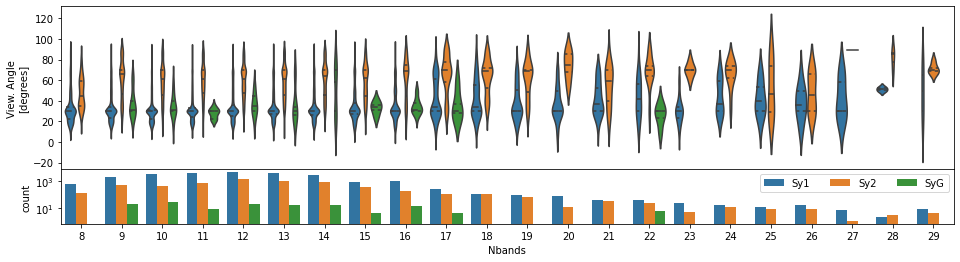

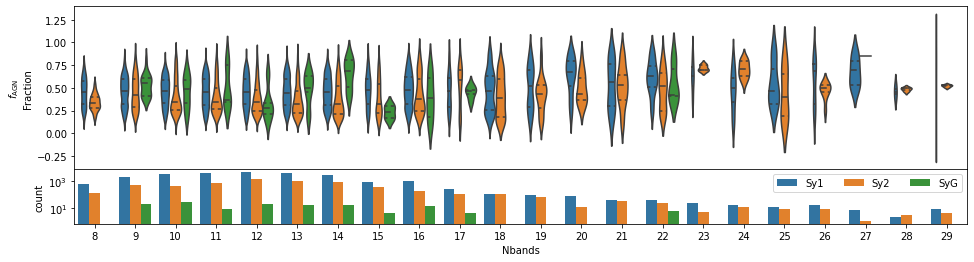

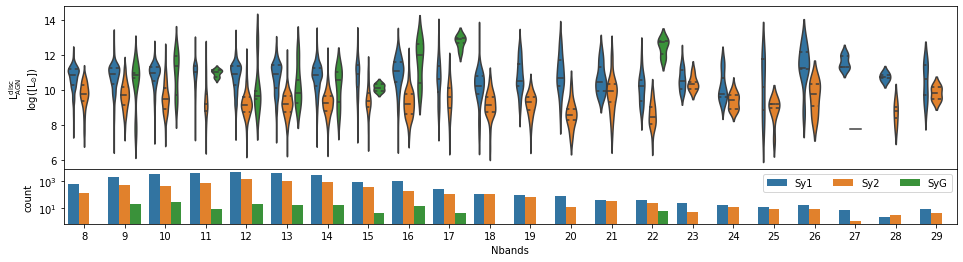

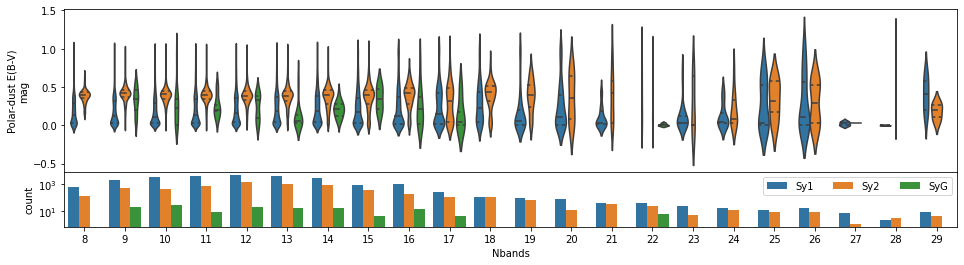

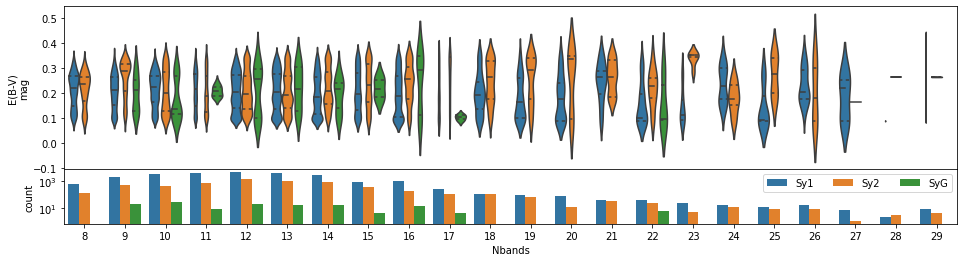

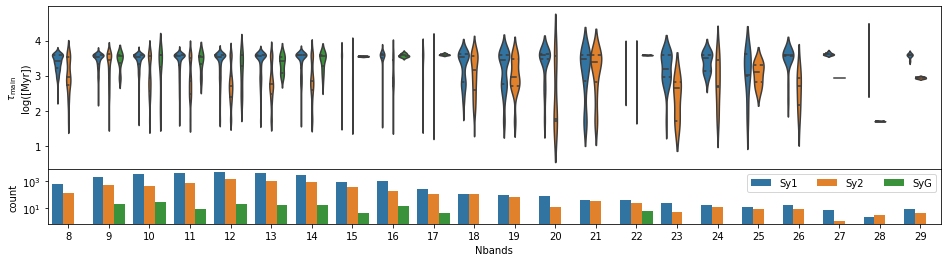

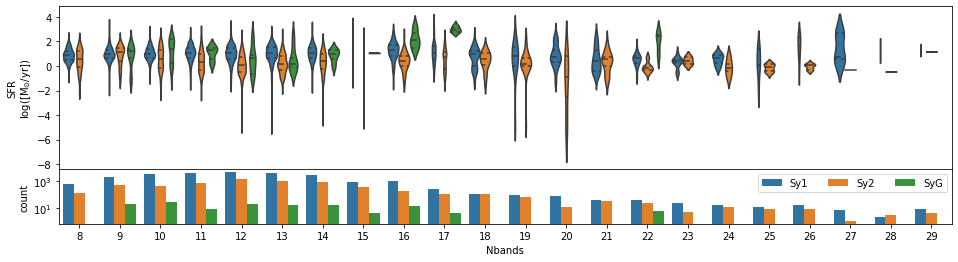

In [7]:
%matplotlib inline
for ipar, parm in enumerate(param_check):
    fig, axs = plt.subplots(2, 1,
                            figsize=(16, 4), sharex=True,
                            gridspec_kw={'height_ratios': [3, 1]})
    ax1 = sns.violinplot(x="Nbands", y=parm, hue="otype_txt",
                         data=SFPandas, inner="quartile", ax=axs[0])
    ax1.get_legend().remove()
    ax1.set_ylabel(param_label[ipar] + "\n" + param_unit[ipar])
    ax2 = sns.countplot(x="Nbands", hue="otype_txt", data=SFPandas, ax=axs[1])
    axs[1].set_yscale('log')
    plt.subplots_adjust(hspace=0.0)
    h, l = ax2.axes.get_legend_handles_labels()
    ax2.axes.legend_.remove()
    ax2.legend(h, l, ncol=3, loc="upper right")

In [8]:
# # Other way to show the same trends

# %matplotlib inline

# a = np.array([[8, 29]])
# plt.figure(figsize=(9, 1.5))
# img = plt.imshow(a, cmap="crest")
# plt.gca().set_visible(False)
# cax = plt.axes([0.2, 0.2, 0.8, 0.25])
# plt.colorbar(orientation="horizontal", cax=cax, label='Number of bands')

# fig, axs = plt.subplots(7, 1, figsize=(10, 30))
# for ipar, parm in enumerate(param_check):
#     ax = sns.kdeplot(data=SFPandas, x=parm, hue="Nbands", legend=True, palette="crest",
#                      common_norm=False, ax=axs[ipar])
#     ax.get_legend().remove()

## Change in the parameters if the band is available
We verify how the parameters change if the band exist or not in the SED fitting. First we create a list, and then we create the image showing all the changes in the density distribution of the parameters.

In [9]:
list_exist = [i for i in SFPandas.columns if i.startswith('Exists_')]

print("Total number of comparisons: ", len(list_exist) * len(param_check))

Total number of comparisons:  217


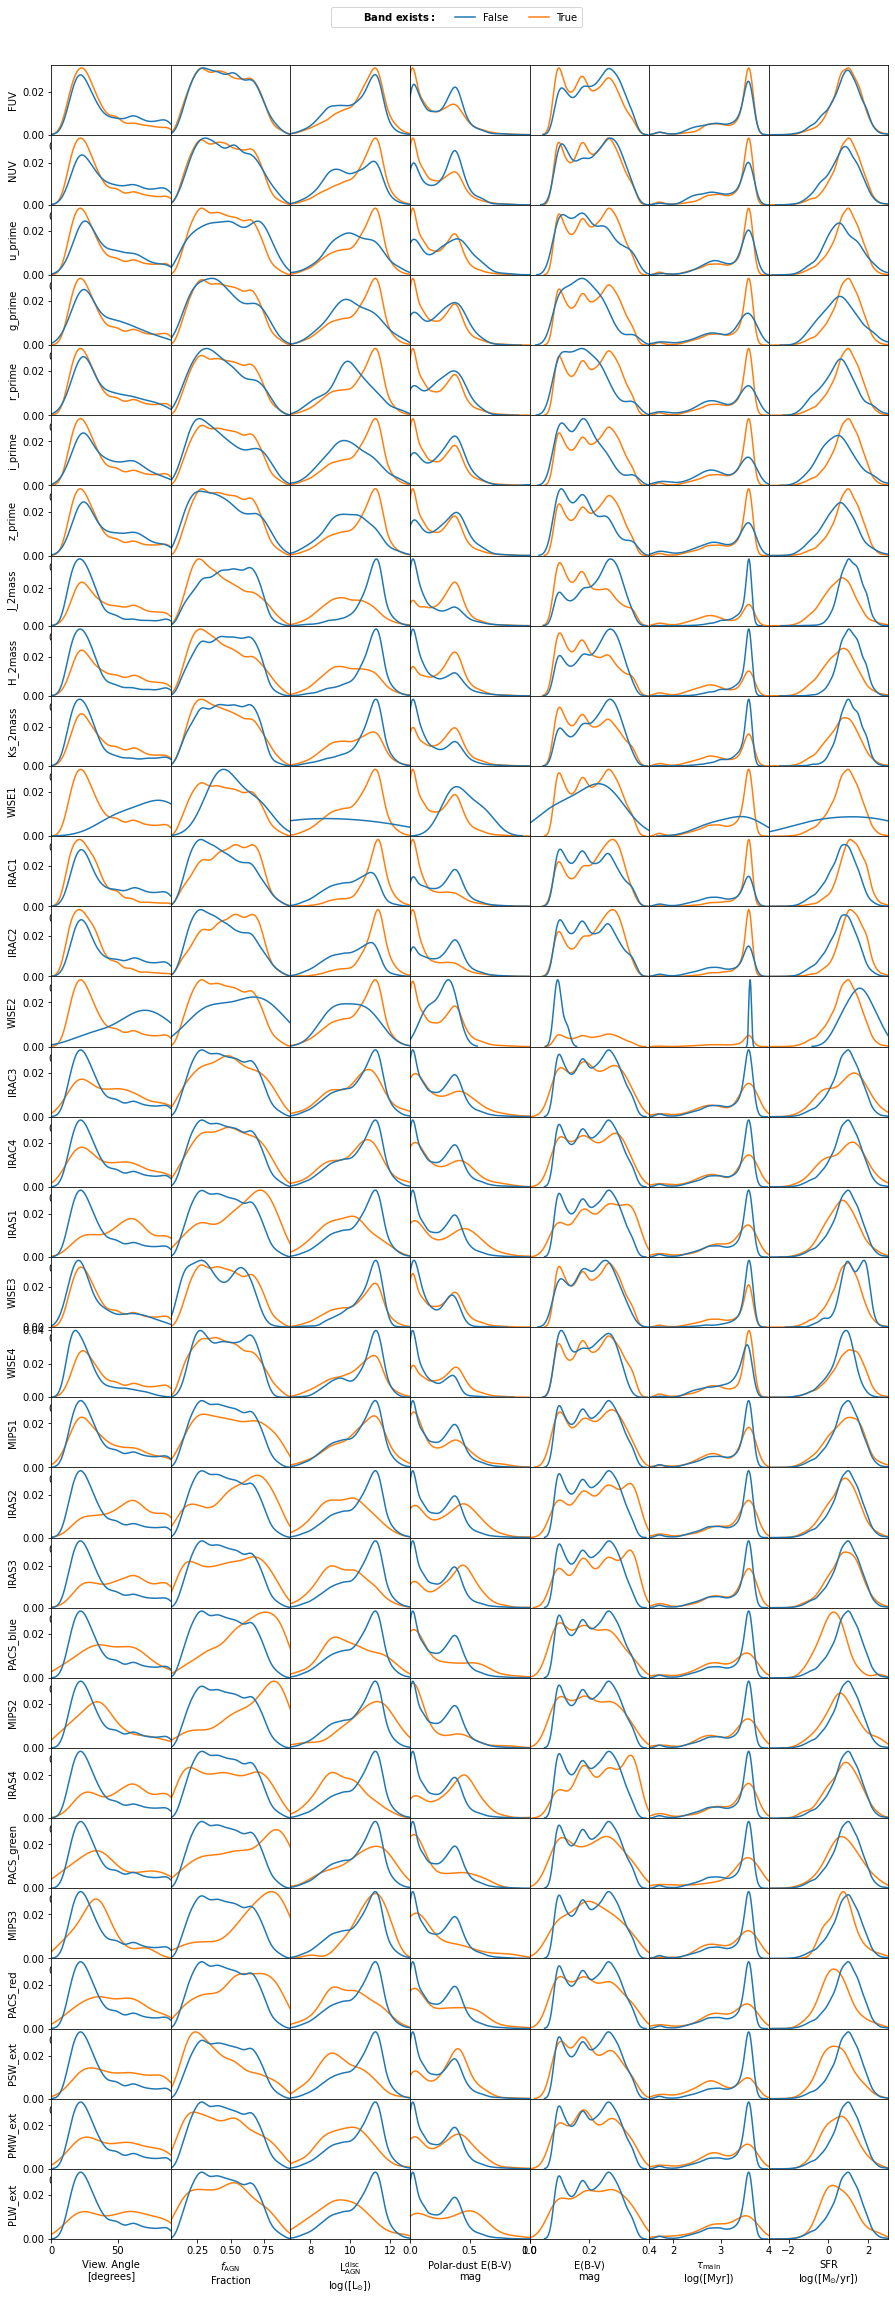

In [10]:
%matplotlib inline
fig, axs = plt.subplots(31, 7, figsize=(15, 40))
for icol, parm in enumerate(param_check):
    for irow, bands in enumerate(list_exist):
        sns.kdeplot(data=SFPandas.loc['SKIRTOR'], x=parm, hue=bands, legend=False,
                    common_norm=False, ax=axs[irow, icol], clip=param_range[icol])
        axs[irow, icol].set_xlim(param_range[icol])
        if icol == 0:
            axs[irow, icol].set_ylabel(bands.split('Exists_')[-1])
        else:
            axs[irow, icol].set_ylabel(None)
            axs[irow, icol].set_yticks([])
        axs[irow, icol].set_xlabel(param_label[icol] + "\n" + param_unit[icol])
plt.subplots_adjust(hspace=0.0, wspace=0.0)

f = plt.gcf()
No_exists = mlines.Line2D([], [], color='C0', label='False')
Yes_exists = mlines.Line2D([], [], color='C1', label='True')
tit_leg = mlines.Line2D([], [], marker="", ls="",
                        label=r"$\rm{\bf{Band\,\,exists:}}$")
leg = f.legend(bbox_to_anchor=(0.0, 0.0, 1.0, 0.9),
               handles=[tit_leg, No_exists, Yes_exists], loc=9, fontsize=10, ncol=6,
               borderaxespad=0.)

The difference in the density distributions can be explained in the way the types of Seyfert galaxies are splited in the sample with or without a given band. We show the counts of galaxies for each of the bands in the following plot.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


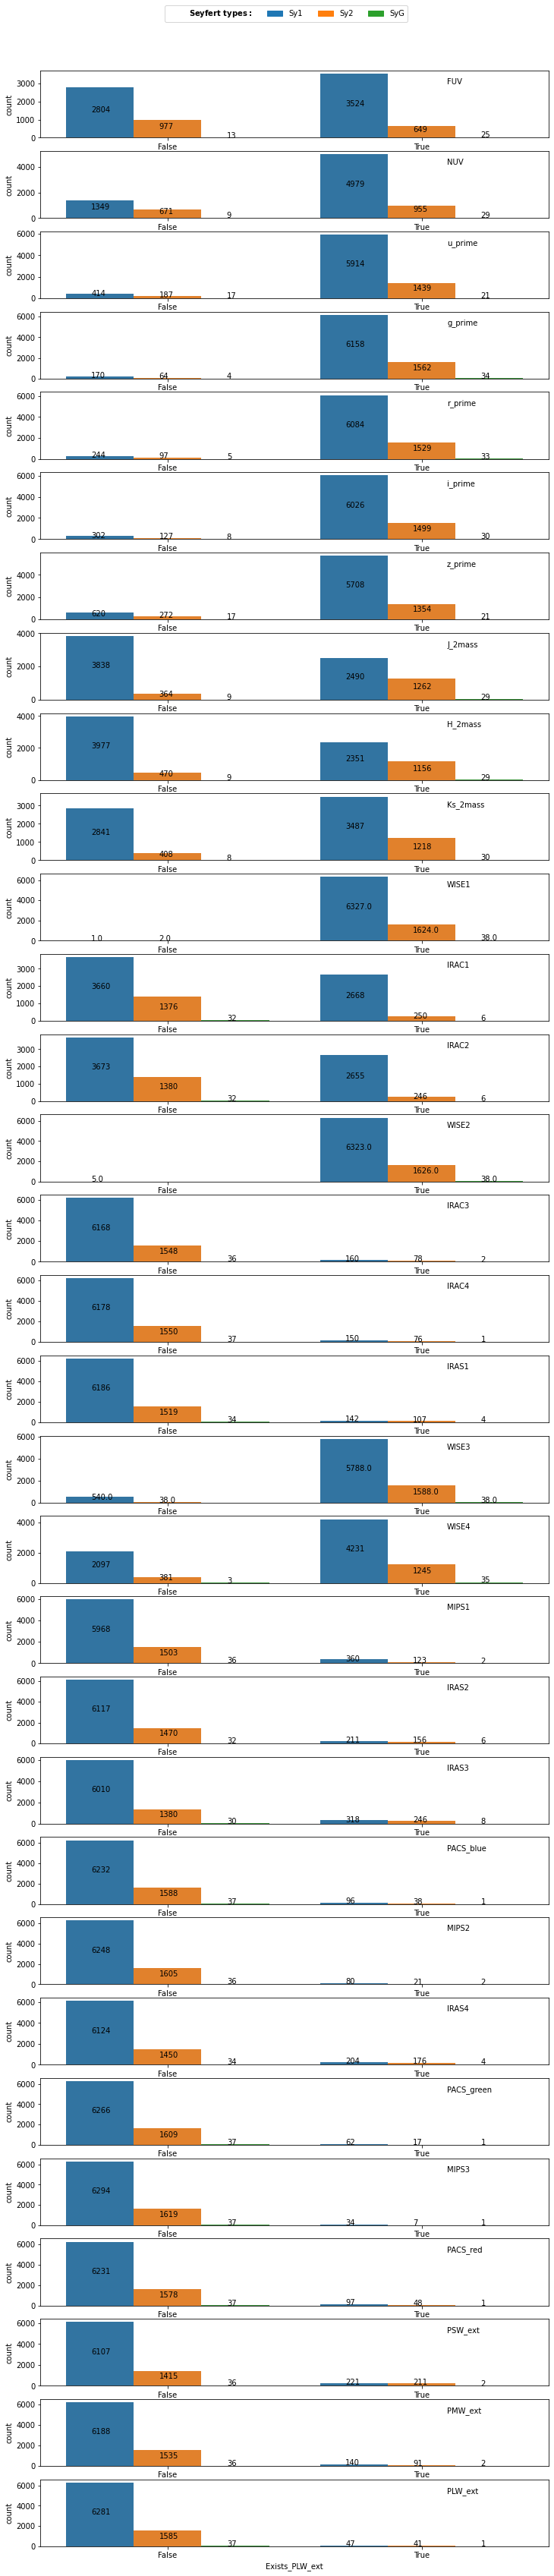

In [11]:
fig, axs = plt.subplots(31, 1, figsize=(12, 60))
for irow, bands in enumerate(list_exist):
    cts = sns.countplot(x=bands, hue="otype_txt",
                        data=SFPandas.loc['SKIRTOR'], ax=axs[irow])
    for ibar, bar in enumerate(cts.patches):
        txt_x = bar.get_x()
        txt_y = bar.get_height()
        axs[irow].text(txt_x+0.1, txt_y/2, txt_y)

    axs[irow].annotate(bands.split('Exists_')[-1],
                       xy=(0.8, 0.8), xycoords='axes fraction')
    axs[irow].get_legend().remove()

f = plt.gcf()
RecSy1 = Rectangle((0, 0), 1, 1, color='C0', label='Sy1')
RecSy2 = Rectangle((0, 0), 1, 1, color='C1', label='Sy2')
RecSyG = Rectangle((0, 0), 1, 1, color='C2', label='SyG')

tit_leg = mlines.Line2D([], [], marker="", ls="",
                        label=r"$\rm{\bf{Seyfert\,\,types:}}$")
leg = f.legend(bbox_to_anchor=(0.0, 0.0, 1.0, 0.9),
               handles=[tit_leg, RecSy1, RecSy2, RecSyG], loc=9, fontsize=10, ncol=4,
               borderaxespad=0.)

Both plots, shows that the lack of data does not impact the results of this work significantly.

##### Notebook information

In [12]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
json      : 2.0.9
numpy     : 1.19.5
matplotlib: 3.4.3
seaborn   : 0.11.1
astropy   : 4.2
autopep8  : 1.5.7
pandas    : 1.2.0

Watermark: 2.2.0

